In [3]:
import os
from osgeo import gdal
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from s2cloudless import S2PixelCloudDetector, CloudMaskRequest

In [4]:
images_path = 'v1_train_source_s2/'
labels_path = 'v1_train_labels/'

images_files = os.listdir('v1_train_source_s2/')
# labels_files = os.listdir('v1_train_labels/')

In [5]:
images_files_info = []

for file in tqdm(images_files):
    if file[:3] == 'ref':
        images_files_info.append([images_path+file+'/', file[54:58], 
                                  pd.to_datetime(file[-10:-6] + '.' + file[-5:-3] + '.' + file[-2:])])
    else:
        print(file)

train_images = pd.DataFrame(images_files_info, columns=['path', 'id', 'date'])

# labels_files_info = []

# for file in tqdm(labels_files):
#     if file[:3] == 'ref':
#         labels_files_info.append([labels_path+file+'/', file[-4:]])
#     else:
#         print(file)

# train_labels = pd.DataFrame(labels_files_info, columns=['path', 'id'])

100%|██████████| 20/20 [00:00<00:00, 3136.28it/s]

.DS_Store


In [6]:
train_images.id = train_images.id.astype(int)
# train_labels.id = train_labels.id.astype(int)

In [217]:
fields_labels_on_image = []

for i, val in tqdm(train_labels.iterrows()):
    
    field_ids = gdal.Open(val['path']+'field_ids.tif').ReadAsArray()
    
    ids = np.unique(field_ids)
    ids = ids[ids != 0]
    
    labels = gdal.Open(val['path']+'labels.tif').ReadAsArray()
    
    for idx in ids:
        
        fields_labels_on_image.append([val['id'], idx, labels[np.where(field_ids == idx)][0]])

fields_labels_on_image = pd.DataFrame(fields_labels_on_image, 
                                      columns=['id', 'field_id', 'label'])

2650it [00:16, 159.41it/s]


In [222]:
train_labels = pd.merge(fields_labels_on_image, train_labels, on=['id'], how='left')

In [235]:
train_labels = train_labels.reset_index(drop=True)

# Clouds

In [149]:
bands_s2 = ['B01.tif', 'B02.tif', 'B03.tif', 'B04.tif', 'B05.tif', 'B06.tif',
            'B07.tif', 'B08.tif', 'B8A.tif', 'B09.tif', 'B11.tif', 'B12.tif']

In [383]:
img1 = train_images.path.values[7]
image = np.zeros((256, 256, 13))
for i, b in enumerate(bands_s2):
    image[:, :, i] = np.divide(gdal.Open(img1+b).ReadAsArray().copy(), 255.)

In [416]:
def get_cloud_mask(raster):
    
    cloud_detector = S2PixelCloudDetector(all_bands=True,
                                          threshold=0.9,
                                          average_over=0,
                                          dilation_size=20
                                         )
    
    return cloud_detector.get_cloud_masks(raster[np.newaxis, :, :, :])[0, :, :]

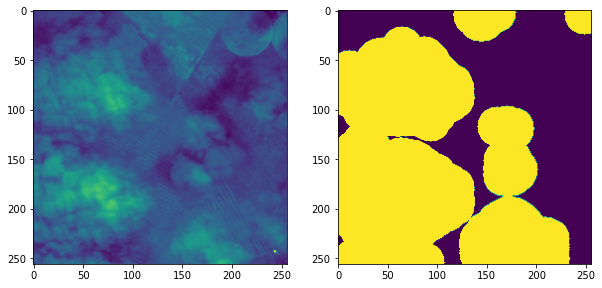

In [417]:
_, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(image[:, :, 7])

cmask = get_cloud_mask(image)

ax[1].imshow(cmask, vmin=0, vmax=1)

plt.show()

In [418]:
cmask

array([[0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int8)

In [423]:
b04[cmask == 1]

array([0.31372549, 0.31764706, 0.32156863, ..., 0.19215686, 0.18039216,
       0.19607843])

In [419]:
# NDVI
def ndvi_calc(B8A, B04):
    ndvi = np.zeros((256, 256))
    np.divide((B8A - B04), (B8A+B04), out=ndvi, where=(B8A+B04)!=0)
    return ndvi

# SOIL ADJUSTED VEGETATION INDEX, SAVI
def savi_calc(B8A, B04):
    savi = np.zeros((256, 256))
    np.divide(1.5*(B8A-B04), (B8A+B04+0.5), out=savi, where=(B8A+B04+0.5)!=0)
    return savi

# ATMOSPHERICALLY RESISTANT VEGETATION INDEX, ARVI
def arvi_calc(B08, B04, B02):
    arvi = np.zeros((256, 256))
    np.divide((B08-(B04-1*(B02-B04))), (B08+(B04-1*(B02-B04))), out=arvi, where=(B08+(B04-1*(B02-B04)))!=0)
    return arvi
    

# EVI - интенсивный индекс растительности
def evi_calc(B8A, B04, B02):
    evi = np.zeros((256, 256))
    np.divide(2.5*(B8A-B04), ((B8A+6*B04-7.5*B02)+1), out=evi, where=((B8A+6*B04-7.5*B02)+1)!=0)
    return evi

# GCI - хлорофил
def gci_calc(B08, B03):
    gci = np.zeros((256, 256))
    np.divide(B08, B03, out=gci, where=B03!=0)
    return gci-1

# SIPI
def sipi_calc(B08, B02, B04):
    sipi = np.zeros((256, 256))
    np.divide((B08-B02), (B08-B04), out=sipi, where=(B08-B04)!=0)
    return sipi

# NBR
def nbr_calc(B8A, B12):
    nbr = np.zeros((256, 256))
    np.divide((B8A-B12), (B8A+B12), out=nbr, where=(B8A+B12)!=0)
    return nbr

# NDWI
def ndwi_calc(B03, B08):
    ndwi = np.zeros((256, 256))
    np.divide((B03-B08), (B03+B08), out=ndwi, where=(B03+B08)!=0)
    return ndwi

# NDSI > 0.4 - снег
def ndsi_calc(B03, B11):
    ndsi = np.zeros((256, 256))
    np.divide((B03-B11), (B03+B11), out=ndsi, where=(B03+B11)!=0)
    return ndsi

# DEFORESTATION INDEX
def deforest_calc(B03, B09, B11, B12):
    return (B03+B09)*(B11+B12)

# FIRE DETECTION INDEX
def fire_calc(B12, B8A, B09):
    fire = np.zeros((256, 256))
    np.divide(B12, (B8A*B09), out=fire, where=(B8A*B09)!=0)
    return fire

# SIMPLE RATIO
def sr_calc(B08, B04):
    sr = np.zeros((256, 256))
    np.divide(B08, B04, out=sr, where=B04!=0)
    return sr

# CHLOROPHYLL INDEX
def cl_green_calc(B08, B03):
    cl = np.zeros((256, 256))
    np.divide(B08, B03, out=cl, where=B03!=0)
    return cl - 1

def cl_rededge_calc(B08, B07):
    cl = np.zeros((256, 256))
    np.divide(B08, B07, out=cl, where=B07!=0)
    return cl - 1

def recl_calc(B8A, B04):
    cl = np.zeros((256, 256))
    np.divide(B8A, B04, out=cl, where=B04!=0)
    return cl - 1

# Normalized Difference Red-Edge Index
def ndre_calc(B09, B04):
    ndre = np.zeros((256, 256))
    np.divide((B09-B04), (B09+B04), out=ndre, where=(B09+B04)!=0)
    return ndre

In [290]:
part1 = train_images.id.unique()[:1000]
part2 = train_images.id.unique()[1000:2000]
part3 = train_images.id.unique()[2000:]

columns = ['id', 'date', 'field_id', 'label']
for indx in ['ndvi', 'savi', 'arvi', 'evi', 'gci', 'sipi', 'nbr', 'ndwi', 'deforest',
             'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12']:
    
    for post in ['mean', 'median']:
        columns.append(indx+'_'+post)

In [297]:
result = []

for image_id in tqdm(part1):
    
    temp_train_images = train_images[train_images.id == image_id]

    for j in range(temp_train_images.shape[0]):
        
        path_to_image = temp_train_images.path.values[j]
        image_date = temp_train_images.date.values[j]
        
        B01 = gdal.Open(path_to_image+'B01.tif').ReadAsArray() / 255.
        B02 = gdal.Open(path_to_image+'B02.tif').ReadAsArray() / 255.
        B03 = gdal.Open(path_to_image+'B03.tif').ReadAsArray() / 255.
        B04 = gdal.Open(path_to_image+'B04.tif').ReadAsArray() / 255.
        B05 = gdal.Open(path_to_image+'B05.tif').ReadAsArray() / 255.
        B06 = gdal.Open(path_to_image+'B06.tif').ReadAsArray() / 255.
        B07 = gdal.Open(path_to_image+'B07.tif').ReadAsArray() / 255.
        B08 = gdal.Open(path_to_image+'B08.tif').ReadAsArray() / 255.
        B8A = gdal.Open(path_to_image+'B8A.tif').ReadAsArray() / 255.
        B09 = gdal.Open(path_to_image+'B09.tif').ReadAsArray() / 255.
        B11 = gdal.Open(path_to_image+'B11.tif').ReadAsArray() / 255.
        B12 = gdal.Open(path_to_image+'B12.tif').ReadAsArray() / 255.
        
#         Ball = np.zeros((256, 256, 13))
#         for i, b in enumerate([B01, B02, B03, B04, B05, B06, B07, B08, B8A, B09, B11, B12]):
#             Ball[:, :, i] = b
#         cloud_mask = get_cloud_mask(b)
        
        ndvi = ndvi_calc(B8A, B04)
        savi = savi_calc(B8A, B04)
        arvi = arvi_calc(B08, B04, B02)
        evi = evi_calc(B8A, B04, B02)
        gci = gci_calc(B08, B03)
        sipi = sipi_calc(B08, B02, B04)
        nbr = nbr_calc(B8A, B12)
        ndwi = ndwi_calc(B03, B08)
        deforest = deforest_calc(B03, B09, B11, B12)
        sr = sr_calc(B08, B04)
        cl_green = cl_green_calc(B08, B03)
        cl_rededge = cl_rededge_calc(B08, B07)
        recl = recl_calc(B8A, B04)
        ndre = ndre_calc(B08, B07)
    
        temp_train_labels = train_labels[train_labels.id == image_id]
        
        for i in range(temp_train_labels.shape[0]):
    
            field_id = temp_train_labels.field_id.values[i]
            label = temp_train_labels.label.values[i]
    
            field_ids = gdal.Open(temp_train_labels.path.values[i]+'field_ids.tif').ReadAsArray()
        
            temp_result = [image_id, image_date, field_id, label]
            
            for indx in [ndvi, savi, arvi, evi, gci, sipi, nbr, ndwi, deforest,
                         B01, B02, B03, B04, B05, B06, B07, B08, B8A, B09, B11, B12]:
                
                indx_masked = indx[(field_ids==field_id)
#                                    &(cmask == 0)
                                  ]
                
                res_mean = indx_masked.mean()
                res_median = np.median(indx_masked)
                
#                 if indx_masked.shape[0] > 0:
#                     res_mean = indx_masked.mean()
#                     res_median = np.percentile(indx_masked, 0.5)
#                 else:
#                     res_mean = np.nan
#                     res_median = np.nan
                
                temp_result.append(res_mean)
                temp_result.append(res_median)
            
            result.append(temp_result)

res = pd.DataFrame(result, columns=columns)
res.to_csv('train1.csv', index=False)

In [294]:
res

,id,date,field_id,label,ndvi_mean,ndvi_median,savi_mean,savi_median,arvi_mean,arvi_median,...,B08_mean,B08_median,B8A_mean,B8A_median,B09_mean,B09_median,B11_mean,B11_median,B12_mean,B12_median
0,2354,2017-11-12,37023,5,0.085675,-0.006722,0.073588,-0.006722,-0.118770,-0.006722,...,0.384342,-0.006722,0.381510,-0.006722,0.387160,-0.006722,0.444262,-0.006722,0.423037,-0.006722
1,2354,2017-11-12,40307,5,0.082498,0.000453,0.071919,0.000453,-0.117472,0.000453,...,0.404507,0.000453,0.399593,0.000453,0.397008,0.000453,0.457028,0.000453,0.436096,0.000453
2,2354,2017-11-12,82050,5,0.086123,0.016078,0.077645,0.016078,-0.113402,0.016078,...,0.421244,0.016078,0.415997,0.016078,0.414445,0.016078,0.476654,0.016078,0.454140,0.016078
3,2354,2017-11-12,92319,5,0.072508,0.004532,0.063610,0.004532,-0.134058,0.004532,...,0.388172,0.004532,0.384250,0.004532,0.384662,0.004532,0.446047,0.004532,0.427135,0.004532
4,2354,2017-09-26,37023,5,0.087054,-0.021485,0.072708,-0.021485,-0.110380,-0.021485,...,0.372964,-0.021485,0.360735,-0.021485,0.363258,-0.021485,0.406494,-0.021485,0.371165,-0.021485
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1683804,1732,2017-05-11,60565,4,0.002585,-0.016722,0.002679,-0.016722,0.090008,-0.016722,...,0.587233,-0.016722,0.577158,-0.016722,1.000000,-0.016722,0.269272,-0.016722,0.241992,-0.016722
1683805,1732,2017-05-11,69597,4,-0.012102,-0.027017,-0.012928,-0.027017,0.079697,-0.027017,...,0.628431,-0.027017,0.606373,-0.027017,1.000000,-0.027017,0.287037,-0.027017,0.260185,-0.027017
1683806,1732,2017-05-11,112613,4,-0.000216,-0.017659,-0.000222,-0.017659,0.075597,-0.017659,...,0.566156,-0.017659,0.559762,-0.017659,1.000000,-0.017659,0.262412,-0.017659,0.235365,-0.017659
1683807,1732,2017-05-11,120512,3,-0.030438,-0.037984,-0.034027,-0.037984,0.095120,-0.037984,...,0.745297,-0.037984,0.709870,-0.037984,1.000000,-0.037984,0.303955,-0.037984,0.239016,-0.037984


In [296]:
result = []

for image_id in tqdm(part2):
    
    temp_train_images = train_images[train_images.id == image_id]

    for j in range(temp_train_images.shape[0]):
        
        path_to_image = temp_train_images.path.values[j]
        image_date = temp_train_images.date.values[j]
        
        B01 = gdal.Open(path_to_image+'B01.tif').ReadAsArray() / 255.
        B02 = gdal.Open(path_to_image+'B02.tif').ReadAsArray() / 255.
        B03 = gdal.Open(path_to_image+'B03.tif').ReadAsArray() / 255.
        B04 = gdal.Open(path_to_image+'B04.tif').ReadAsArray() / 255.
        B05 = gdal.Open(path_to_image+'B05.tif').ReadAsArray() / 255.
        B06 = gdal.Open(path_to_image+'B06.tif').ReadAsArray() / 255.
        B07 = gdal.Open(path_to_image+'B07.tif').ReadAsArray() / 255.
        B08 = gdal.Open(path_to_image+'B08.tif').ReadAsArray() / 255.
        B8A = gdal.Open(path_to_image+'B8A.tif').ReadAsArray() / 255.
        B09 = gdal.Open(path_to_image+'B09.tif').ReadAsArray() / 255.
        B11 = gdal.Open(path_to_image+'B11.tif').ReadAsArray() / 255.
        B12 = gdal.Open(path_to_image+'B12.tif').ReadAsArray() / 255.
        
        ndvi = ndvi_calc(B8A, B04)
        savi = savi_calc(B8A, B04)
        arvi = arvi_calc(B08, B04, B02)
        evi = evi_calc(B8A, B04, B02)
        gci = gci_calc(B08, B03)
        sipi = sipi_calc(B08, B02, B04)
        nbr = nbr_calc(B8A, B12)
        ndwi = ndwi_calc(B03, B08)
        deforest = deforest_calc(B03, B09, B11, B12)
    
        temp_train_labels = train_labels[train_labels.id == image_id]
        
        for i in range(temp_train_labels.shape[0]):
    
            field_id = temp_train_labels.field_id.values[i]
            label = temp_train_labels.label.values[i]
    
            field_ids = gdal.Open(temp_train_labels.path.values[i]+'field_ids.tif').ReadAsArray()
        
            temp_result = [image_id, image_date, field_id, label]
            
            for indx in [ndvi, savi, arvi, evi, gci, sipi, nbr, ndwi, deforest,
                         B01, B02, B03, B04, B05, B06, B07, B08, B8A, B09, B11, B12]:
                
                res_mean = indx[np.where(field_ids==field_id)].mean()
                res_median = np.percentile(ndvi[np.where(field_ids==field_id)], 0.5)
                
                temp_result.append(res_mean)
                temp_result.append(res_median)
            
            result.append(temp_result)

res = pd.DataFrame(result, columns=columns)
res.to_csv('train2.csv', index=False)

100%|██████████| 1000/1000 [3:39:57<00:00, 13.20s/it] 


In [299]:
result = []

for image_id in tqdm(part3):
    
    temp_train_images = train_images[train_images.id == image_id]

    for j in range(temp_train_images.shape[0]):
        
        path_to_image = temp_train_images.path.values[j]
        image_date = temp_train_images.date.values[j]
        
        B01 = gdal.Open(path_to_image+'B01.tif').ReadAsArray() / 255.
        B02 = gdal.Open(path_to_image+'B02.tif').ReadAsArray() / 255.
        B03 = gdal.Open(path_to_image+'B03.tif').ReadAsArray() / 255.
        B04 = gdal.Open(path_to_image+'B04.tif').ReadAsArray() / 255.
        B05 = gdal.Open(path_to_image+'B05.tif').ReadAsArray() / 255.
        B06 = gdal.Open(path_to_image+'B06.tif').ReadAsArray() / 255.
        B07 = gdal.Open(path_to_image+'B07.tif').ReadAsArray() / 255.
        B08 = gdal.Open(path_to_image+'B08.tif').ReadAsArray() / 255.
        B8A = gdal.Open(path_to_image+'B8A.tif').ReadAsArray() / 255.
        B09 = gdal.Open(path_to_image+'B09.tif').ReadAsArray() / 255.
        B11 = gdal.Open(path_to_image+'B11.tif').ReadAsArray() / 255.
        B12 = gdal.Open(path_to_image+'B12.tif').ReadAsArray() / 255.
        
        ndvi = ndvi_calc(B8A, B04)
        savi = savi_calc(B8A, B04)
        arvi = arvi_calc(B08, B04, B02)
        evi = evi_calc(B8A, B04, B02)
        gci = gci_calc(B08, B03)
        sipi = sipi_calc(B08, B02, B04)
        nbr = nbr_calc(B8A, B12)
        ndwi = ndwi_calc(B03, B08)
        deforest = deforest_calc(B03, B09, B11, B12)
    
        temp_train_labels = train_labels[train_labels.id == image_id]
        
        for i in range(temp_train_labels.shape[0]):
    
            field_id = temp_train_labels.field_id.values[i]
            label = temp_train_labels.label.values[i]
    
            field_ids = gdal.Open(temp_train_labels.path.values[i]+'field_ids.tif').ReadAsArray()
        
            temp_result = [image_id, image_date, field_id, label]
            
            for indx in [ndvi, savi, arvi, evi, gci, sipi, nbr, ndwi, deforest,
                         B01, B02, B03, B04, B05, B06, B07, B08, B8A, B09, B11, B12]:
                
                res_mean = indx[np.where(field_ids==field_id)].mean()
                res_median = np.percentile(ndvi[np.where(field_ids==field_id)], 0.5)
                
                temp_result.append(res_mean)
                temp_result.append(res_median)
            
            result.append(temp_result)

res = pd.DataFrame(result, columns=columns)
res.to_csv('train3.csv', index=False)

100%|██████████| 650/650 [4:04:44<00:00, 22.59s/it]    
